In [1]:
import numpy as np
import pickle
from numpy.random import default_rng
import matplotlib.pyplot as plt

Loading Gaussian Mixture parameters

In [2]:
with open('DGM_SUT_H5_density.pkl', 'rb') as f:
    gmm_params = pickle.load(f)

Weights $w_k$

In [3]:
gmm_params['weights'].shape

(150,)

Means $\mu_k$

In [4]:
gmm_params['means'].shape

(150, 2)

Covariances $Σ_k$

In [5]:
gmm_params['covariances'].shape

(150, 2, 2)

In [6]:
weights = gmm_params['weights'] 
means   = gmm_params['means'] 
covs    = gmm_params['covariances'] 
K = len(weights)

In [7]:
def gaussian_pdf(x, mean, cov):
    d = x.shape[1]
    diff = x - mean[None,:]
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    denom = np.sqrt((2*np.pi)**d * np.linalg.det(cov))
    return np.exp(exponent) / denom

In [10]:
def log_pi(x):
    Npts = x.shape[0]
    pdf_vals = np.zeros((Npts, K))
    for k in range(K):
        pdf_vals[:,k] = weights[k] * gaussian_pdf(x, means[k], covs[k])
    return np.log(pdf_vals.sum(axis=1) + 1e-30)

def grad_log_pi(x):
    Npts = x.shape[0]
    pdf_vals = np.zeros((Npts, K))
    inv_covs = [np.linalg.inv(covs[k]) for k in range(K)]
    for k in range(K):
        pdf_vals[:,k] = weights[k] * gaussian_pdf(x, means[k], covs[k])
    denom = pdf_vals.sum(axis=1, keepdims=True) + 1e-30

    num = np.zeros((Npts, 2))
    for k in range(K):
        diff = (means[k] - x) 
        tmp = (pdf_vals[:,k,None]) * (inv_covs[k] @ diff.T).T
        num += tmp

    return num / denom

In [12]:
def simulate_langevin(x_init, tau=1e-3, n_steps=500, diffusion_cov=None, seed=42):
    rng = default_rng(seed)
    x = x_init.copy()
    for t in range(n_steps):
        g = grad_log_pi(x)
        x += tau*g
        if diffusion_cov is not None:
            z = rng.normal(size=x.shape)
            chol = np.linalg.cholesky(2.0 * tau * diffusion_cov)
            noise = z @ chol.T
            x += noise
    return x


In [13]:
rng = default_rng(0)
N = 10_000
x0 = rng.normal(loc=0.0, scale=1.0, size=(N,2))

# PART (A): No diffusion
xa = simulate_langevin(x0, tau=1e-3, n_steps=500, diffusion_cov=None)

# PART (B): Add diffusion with tau=1e-3, covariance=I
xb = simulate_langevin(x0, tau=1e-3, n_steps=500, diffusion_cov=np.eye(2))

# PART (C): Same as (B) but smaller step size tau=1e-4
xb_small = simulate_langevin(x0, tau=1e-4, n_steps=500, diffusion_cov=np.eye(2))

# PART (D): Non-isotropic diffusion covariance
diff_cov = np.array([[2.0, 0.0],[0.0, 0.1]])
xd = simulate_langevin(x0, tau=1e-3, n_steps=500, diffusion_cov=diff_cov)

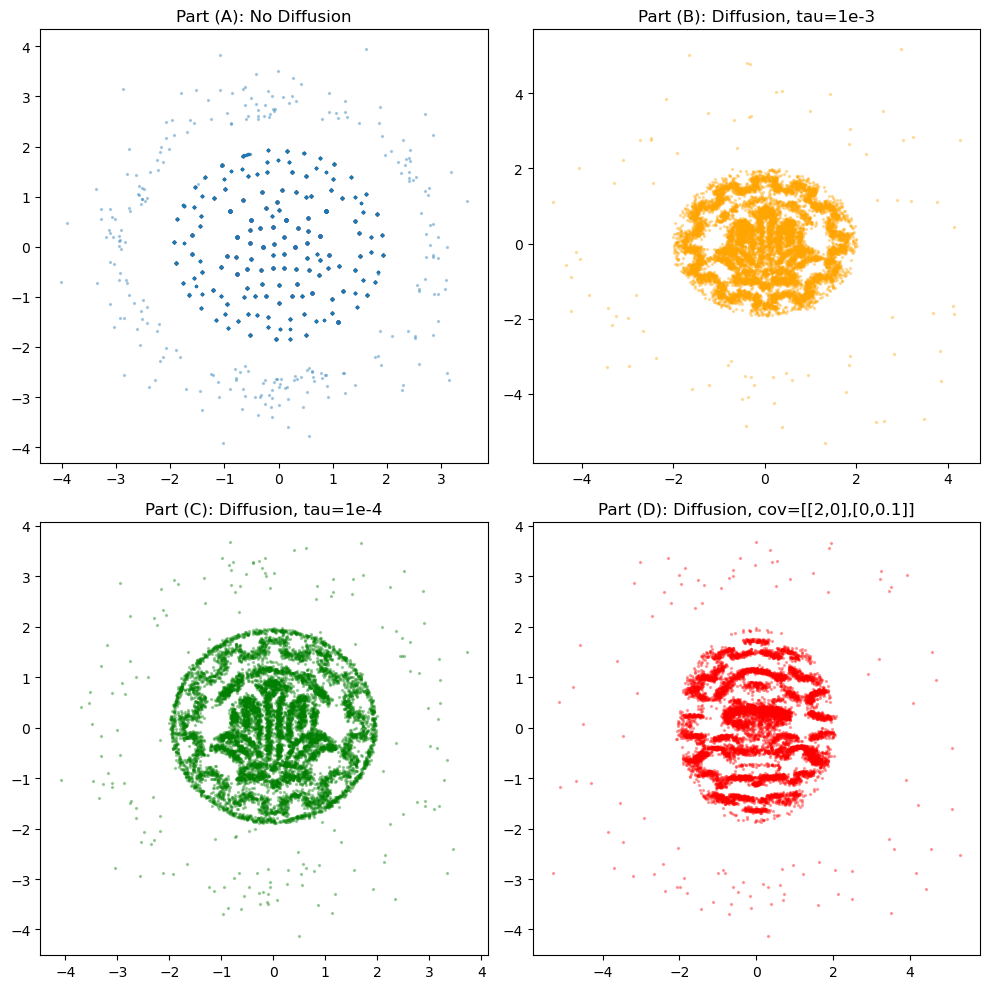

In [14]:
# 5. Make scatter plots of final samples
fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.ravel()

axes[0].scatter(xa[:,0], xa[:,1], s=2, alpha=0.3)
axes[0].set_title("Part (A): No Diffusion")

axes[1].scatter(xb[:,0], xb[:,1], s=2, alpha=0.3, color='orange')
axes[1].set_title("Part (B): Diffusion, tau=1e-3")

axes[2].scatter(xb_small[:,0], xb_small[:,1], s=2, alpha=0.3, color='green')
axes[2].set_title("Part (C): Diffusion, tau=1e-4")

axes[3].scatter(xd[:,0], xd[:,1], s=2, alpha=0.3, color='red')
axes[3].set_title("Part (D): Diffusion, cov=[[2,0],[0,0.1]]")

plt.tight_layout()
plt.show()

## Observations Interpretation

### A) No-Noise Case

- In this case, only the gradient of $\log \pi$ affects the samples, pushing them toward the maxima of $\pi$ (or the local maxima of the density).
- If $\pi$ is multi-modal (i.e., it has several peaks), the samples typically concentrate around the dominant modes after a few steps.
- **The main issue** with this approach is that in the presence of multiple modes, the samples cannot transition between modes. As a result, the diversity needed to represent the entire distribution is not achieved.

### B) Isotropic Noise ($\tau = 10^{-3}$)

- Adding noise allows the chain to escape from one mode and move to others. As a result, there is greater dispersion in the final samples, and (theoretically) the samples can explore all high-density regions.
- If the step size ($\tau$) is too large, the chain may exhibit erratic "jumps" or even diverge. However, in this case, $\tau = 10^{-3}$ provides satisfactory performance.

### C) Isotropic Noise with $\tau = 10^{-4}$

- Reducing the step size ($\tau$) makes the movements of the samples more precise but slower. Consequently, the chains will need more time to fully explore the distribution, but the positions of the samples at each step will be more accurate.
- In the plots, the final distribution may appear more converged and orderly because the number of steps is fixed and the step size is smaller.

### D) Anisotropic Noise (Covariance $\begin{pmatrix} 2 & 0 \\ 0 & 0.1 \end{pmatrix}$)

- In this case, the noise has greater strength in one direction (2) and weaker strength in the other (0.1). This causes the samples to spread more widely in the first dimension and more narrowly in the second dimension.
- Such behavior is sometimes used to optimize the mixing of the chain in directions where the main variance of the distribution is high or low.

---

### Final Summary

Adding stochastic noise to the Langevin dynamics chain helps the samples transition between different modes of the distribution $\pi$, resulting in samples that better represent the overall distribution, not just the dominant modes. Selecting an appropriate **noise covariance** and **step size ($\tau$)** plays a crucial role in the speed of convergence and the accuracy of the samples.
